# GoldenHour: Data Exploration and Time Series Analysis

**Objective**: Explore the gold/silver price dataset and geopolitical risk index to understand:
- Dataset structure and completeness
- Temporal patterns and trends
- Relationship between precious metal prices and geopolitical risk
- Stationarity characteristics

**Dataset**: `data/gold_silver.csv` (10,573+ daily observations from 1985-2025)

## 1. Import Required Libraries

In [3]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical tests
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Plot settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


## 2. Load and Inspect Dataset

In [4]:
# Load dataset
df = pd.read_csv('../data/gold_silver.csv')

# Display basic information
print("Dataset Shape:", df.shape)
print("\nColumn Names:")
print(df.columns.tolist())
print("\nFirst 5 rows:")
df.head()

Dataset Shape: (10571, 15)

Column Names:
['DATE', 'GOLD_PRICE', 'GOLD_OPEN', 'GOLD_HIGH', 'GOLD_LOW', 'GOLD_CHANGE_%', 'SILVER_PRICE', 'SILVER_OPEN', 'SILVER_HIGH', 'SILVER_LOW', 'SILVER_CHANGE_%', 'GPRD', 'GPRD_ACT', 'GPRD_THREAT', 'EVENT']

First 5 rows:


,DATE,GOLD_PRICE,GOLD_OPEN,GOLD_HIGH,GOLD_LOW,GOLD_CHANGE_%,SILVER_PRICE,SILVER_OPEN,SILVER_HIGH,SILVER_LOW,SILVER_CHANGE_%,GPRD,GPRD_ACT,GPRD_THREAT,EVENT
0,2025-09-10,3630.90,3633.61,3634.42,3620.90,-0.07,40.92,40.89,40.94,40.72,0.09,NaN,NaN,NaN,NaN
1,2025-09-09,3633.61,3637.10,3674.75,3625.33,-0.06,40.89,41.34,41.50,40.77,-1.13,NaN,NaN,NaN,NaN
2,2025-09-08,3635.84,3586.82,3646.60,3579.67,1.24,41.36,41.01,41.68,40.51,1.20,117.26,97.42,146.26,NaN
3,2025-09-07,3591.19,3592.07,3596.56,3586.95,0.12,40.86,41.00,41.01,40.76,-0.34,83.51,111.00,92.59,NaN
4,2025-09-05,3586.81,3547.00,3600.33,3540.05,1.15,41.01,40.69,41.44,40.55,0.76,166.42,110.61,224.05,NaN


In [5]:
# Data types and missing values
print("Data Types and Missing Values:")
print("="*60)
info_df = pd.DataFrame({
    'Column': df.columns,
    'Dtype': df.dtypes.values,
    'Non-Null Count': df.count().values,
    'Null Count': df.isnull().sum().values,
    'Null %': (df.isnull().sum() / len(df) * 100).values
})
info_df

Data Types and Missing Values:


,Column,Dtype,Non-Null Count,Null Count,Null %
0,DATE,object,10571,0,0.000000
1,GOLD_PRICE,float64,10571,0,0.000000
2,GOLD_OPEN,float64,10571,0,0.000000
3,GOLD_HIGH,float64,10571,0,0.000000
4,GOLD_LOW,float64,10571,0,0.000000
5,GOLD_CHANGE_%,float64,10571,0,0.000000
6,SILVER_PRICE,float64,10564,7,0.066219
7,SILVER_OPEN,float64,10564,7,0.066219
8,SILVER_HIGH,float64,10564,7,0.066219
9,SILVER_LOW,float64,10564,7,0.066219


### 2.1 Dataset Metadata and Header Information

**Note on GDELT Headers**: The `data/headers/` folder contains metadata for two GDELT (Global Database of Events, Language, and Tone) time periods:
- `header_01-1979_03-2013.txt`: GDELT 1.0 schema (56 columns)
- `header_04-2013_10-2025.txt`: GDELT 2.0 schema (57 columns, added SOURCEURL)

These headers document the **original source** of the geopolitical risk data but are **not used for loading** the CSV. The `gold_silver.csv` file is already processed with a unified structure across all years.

In [6]:
# Convert DATE to datetime and set as index with Business Day frequency
df['DATE'] = pd.to_datetime(df['DATE'])
df = df.sort_values('DATE')
df.set_index('DATE', inplace=True)

# CRITICAL: Set Business Day frequency for correct lag interpretation
df = df.asfreq('B')

print("✓ Date index configured with Business Day frequency ('B')")
print(f"\nDate Range: {df.index.min()} to {df.index.max()}")
print(f"Total Business Days: {len(df)}")
print(f"Index Frequency: {df.index.freq}")

✓ Date index configured with Business Day frequency ('B')

Date Range: 1985-01-02 00:00:00 to 2025-09-10 00:00:00
Total Business Days: 10616
Index Frequency: <BusinessDay>


In [7]:
# Analyze GPR missing values
print("GPR Data Completeness Analysis:")
print("="*70)
print(f"Total observations: {len(df)}")
print(f"Missing GPRD values: {df['GPRD'].isnull().sum()} ({df['GPRD'].isnull().sum()/len(df)*100:.2f}%)")
print(f"Missing GPRD_ACT values: {df['GPRD_ACT'].isnull().sum()} ({df['GPRD_ACT'].isnull().sum()/len(df)*100:.2f}%)")
print(f"Missing GPRD_THREAT values: {df['GPRD_THREAT'].isnull().sum()} ({df['GPRD_THREAT'].isnull().sum()/len(df)*100:.2f}%)")

# Show date range of missing GPR data
if df['GPRD'].isnull().any():
    missing_gprd = df[df['GPRD'].isnull()]
    print(f"\nMissing GPR date range: {missing_gprd.index.min()} to {missing_gprd.index.max()}")
    print(f"Last available GPR date: {df[df['GPRD'].notna()].index.max()}")
    
    # For modeling, we'll use only the period with complete GPR data
    df_complete = df[df['GPRD'].notna()].copy()
    print(f"\n✓ Created df_complete with {len(df_complete)} observations (GPR available)")
else:
    df_complete = df.copy()
    print("\n✓ No missing GPR values detected")

GPR Data Completeness Analysis:
Total observations: 10616
Missing GPRD values: 48 (0.45%)
Missing GPRD_ACT values: 48 (0.45%)
Missing GPRD_THREAT values: 48 (0.45%)

Missing GPR date range: 1985-02-18 00:00:00 to 2025-09-10 00:00:00
Last available GPR date: 2025-09-08 00:00:00

✓ Created df_complete with 10568 observations (GPR available)


### 2.2 Handle Missing GPR Values

**Critical Issue**: Some recent dates have missing GPR data (likely not yet published)

## 3. Descriptive Statistics

In [8]:
# Summary statistics for key variables
key_vars = ['GOLD_PRICE', 'SILVER_PRICE', 'GPRD', 'GPRD_ACT', 'GPRD_THREAT']
df[key_vars].describe().round(2)

,GOLD_PRICE,SILVER_PRICE,GPRD,GPRD_ACT,GPRD_THREAT
count,10570.00,10563.00,10568.00,10568.00,10568.00
mean,887.02,12.82,110.46,106.91,113.97
std,665.70,9.19,62.35,94.02,65.02
min,252.55,3.54,9.49,0.00,0.00
25%,361.06,5.13,74.87,58.24,72.12
50%,462.30,7.63,98.60,88.24,100.62
75%,1312.00,18.14,131.06,130.36,139.73
max,3635.84,48.45,1045.60,1627.43,809.49


In [9]:
# Check for outliers using IQR method
def detect_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return len(outliers), lower_bound, upper_bound

print("Outlier Analysis (IQR Method):")
print("="*70)
for col in ['GOLD_PRICE', 'SILVER_PRICE', 'GPRD']:
    n_outliers, lower, upper = detect_outliers(df, col)
    print(f"{col:20} | Outliers: {n_outliers:4} | Range: [{lower:.2f}, {upper:.2f}]")

Outlier Analysis (IQR Method):
GOLD_PRICE           | Outliers:  173 | Range: [-1065.34, 2738.41]
SILVER_PRICE         | Outliers:  119 | Range: [-14.39, 37.66]
GPRD                 | Outliers:  393 | Range: [-9.42, 215.35]


## 4. Time Series Visualization

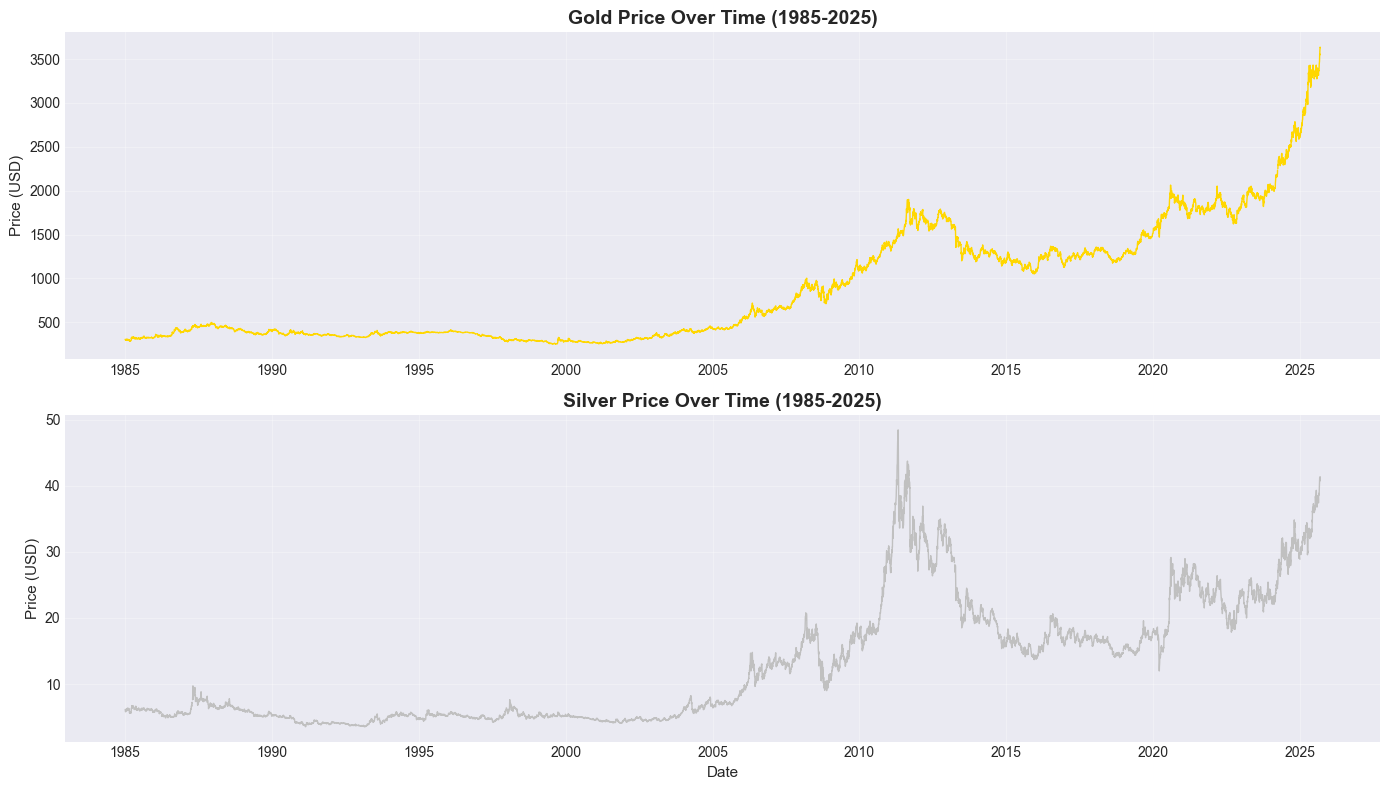

In [10]:
# Plot Gold and Silver prices over time
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Gold price
axes[0].plot(df.index, df['GOLD_PRICE'], color='gold', linewidth=1)
axes[0].set_title('Gold Price Over Time (1985-2025)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Price (USD)', fontsize=11)
axes[0].grid(True, alpha=0.3)

# Silver price
axes[1].plot(df.index, df['SILVER_PRICE'], color='silver', linewidth=1)
axes[1].set_title('Silver Price Over Time (1985-2025)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Price (USD)', fontsize=11)
axes[1].set_xlabel('Date', fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

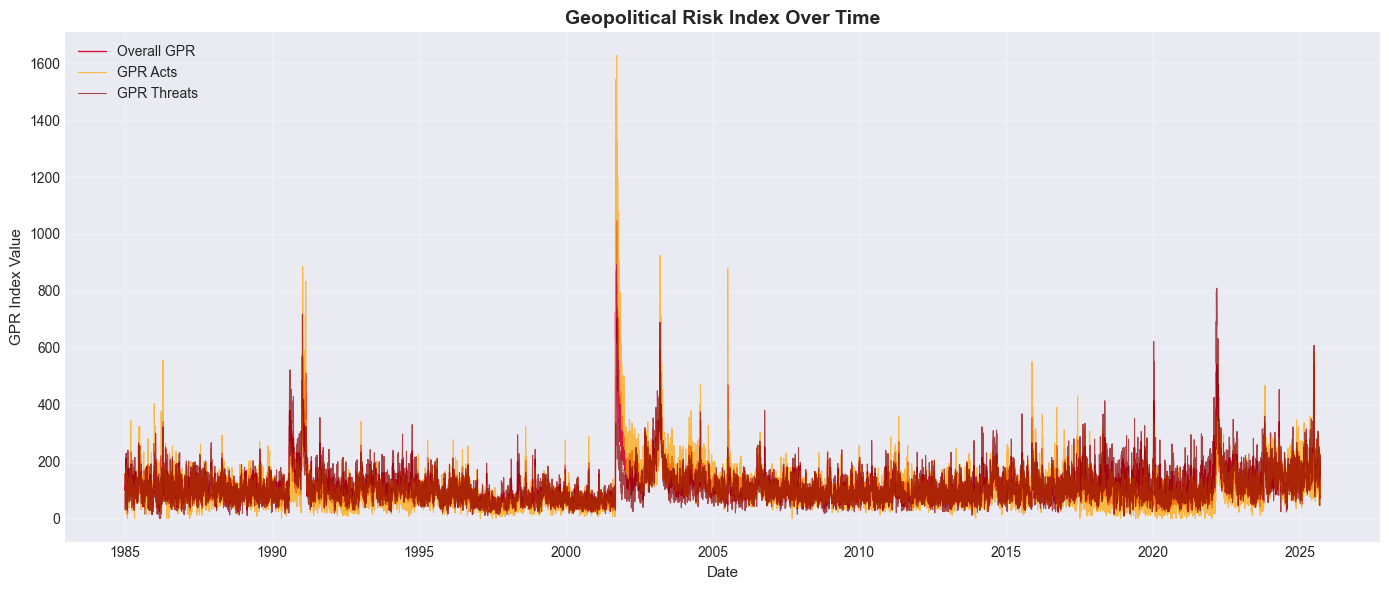

In [11]:
# Plot Geopolitical Risk Index
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(df.index, df['GPRD'], color='crimson', linewidth=1, label='Overall GPR')
ax.plot(df.index, df['GPRD_ACT'], color='orange', linewidth=0.8, alpha=0.7, label='GPR Acts')
ax.plot(df.index, df['GPRD_THREAT'], color='darkred', linewidth=0.8, alpha=0.7, label='GPR Threats')

ax.set_title('Geopolitical Risk Index Over Time', fontsize=14, fontweight='bold')
ax.set_ylabel('GPR Index Value', fontsize=11)
ax.set_xlabel('Date', fontsize=11)
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

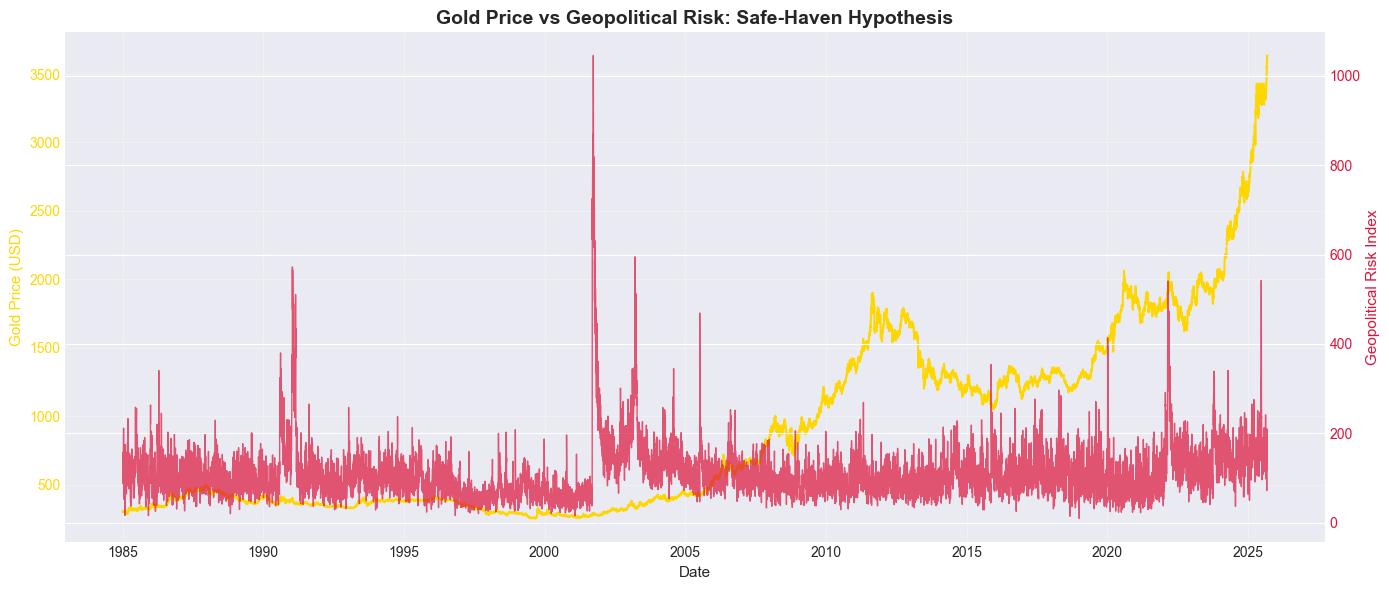

In [12]:
# Dual-axis plot: Gold Price vs GPR Index
fig, ax1 = plt.subplots(figsize=(14, 6))

# Gold price on left y-axis
color = 'gold'
ax1.set_xlabel('Date', fontsize=11)
ax1.set_ylabel('Gold Price (USD)', color=color, fontsize=11)
ax1.plot(df.index, df['GOLD_PRICE'], color=color, linewidth=1.5, label='Gold Price')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, alpha=0.3)

# GPR on right y-axis
ax2 = ax1.twinx()
color = 'crimson'
ax2.set_ylabel('Geopolitical Risk Index', color=color, fontsize=11)
ax2.plot(df.index, df['GPRD'], color=color, linewidth=1, alpha=0.7, label='GPR Index')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Gold Price vs Geopolitical Risk: Safe-Haven Hypothesis', fontsize=14, fontweight='bold')
fig.tight_layout()
plt.show()

## 5. Log Returns Calculation

**Critical Transformation**: Convert prices to log returns for stationarity

In [13]:
# Calculate log returns
df['GOLD_LOG_RETURN'] = np.log(df['GOLD_PRICE']) - np.log(df['GOLD_PRICE'].shift(1))
df['SILVER_LOG_RETURN'] = np.log(df['SILVER_PRICE']) - np.log(df['SILVER_PRICE'].shift(1))

# Remove NaN from first row
df_returns = df.dropna(subset=['GOLD_LOG_RETURN', 'SILVER_LOG_RETURN'])

print(f"Log returns calculated for {len(df_returns)} observations")
print("\nLog Returns Summary:")
df_returns[['GOLD_LOG_RETURN', 'SILVER_LOG_RETURN']].describe().round(6)

Log returns calculated for 10511 observations

Log Returns Summary:


,GOLD_LOG_RETURN,SILVER_LOG_RETURN
count,10511.000000,10511.000000
mean,0.000229,0.000189
std,0.009758,0.017441
min,-0.088756,-0.229874
25%,-0.004309,-0.007518
50%,0.000136,0.000000
75%,0.005005,0.008724
max,0.104371,0.138642


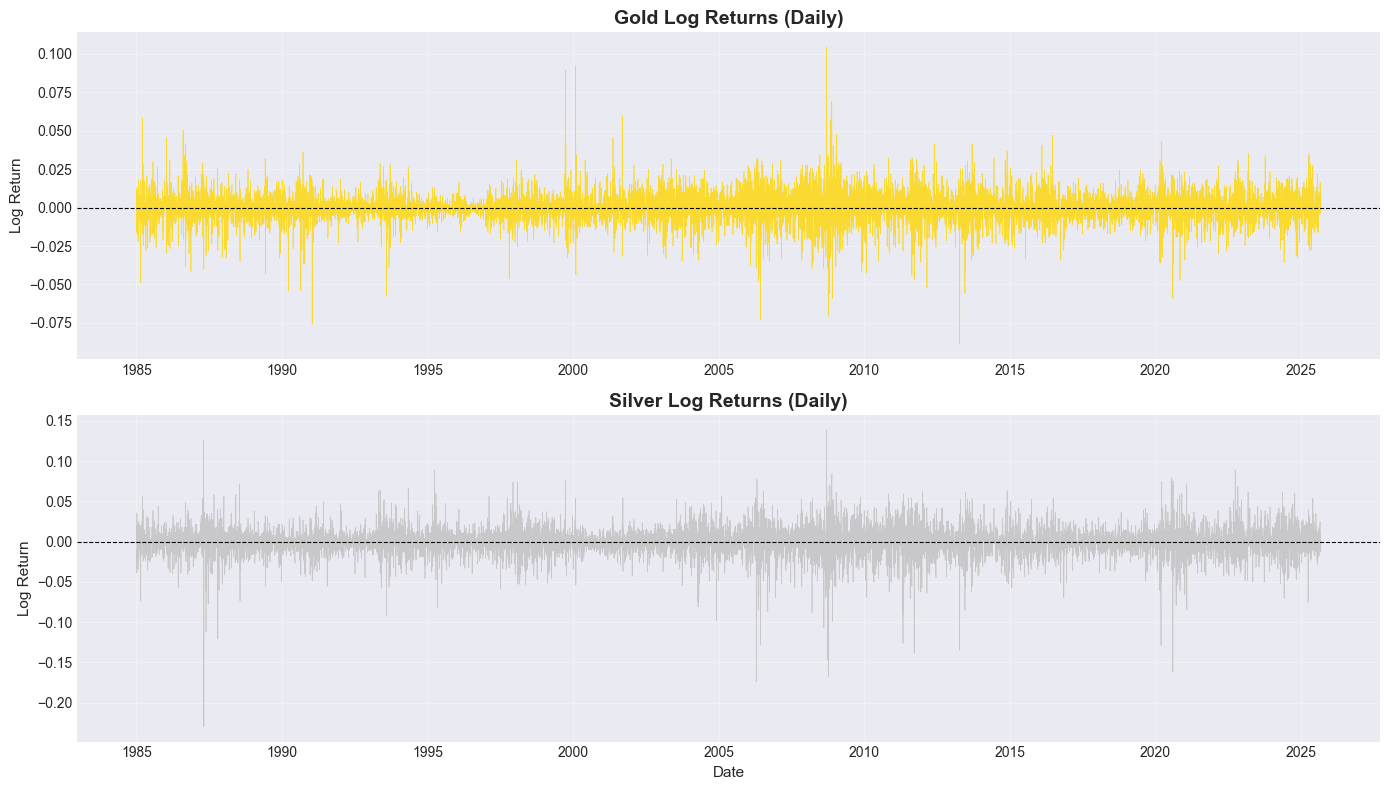

In [14]:
# Plot log returns
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Gold log returns
axes[0].plot(df_returns.index, df_returns['GOLD_LOG_RETURN'], color='gold', linewidth=0.5, alpha=0.8)
axes[0].axhline(y=0, color='black', linestyle='--', linewidth=0.8)
axes[0].set_title('Gold Log Returns (Daily)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Log Return', fontsize=11)
axes[0].grid(True, alpha=0.3)

# Silver log returns
axes[1].plot(df_returns.index, df_returns['SILVER_LOG_RETURN'], color='silver', linewidth=0.5, alpha=0.8)
axes[1].axhline(y=0, color='black', linestyle='--', linewidth=0.8)
axes[1].set_title('Silver Log Returns (Daily)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Log Return', fontsize=11)
axes[1].set_xlabel('Date', fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

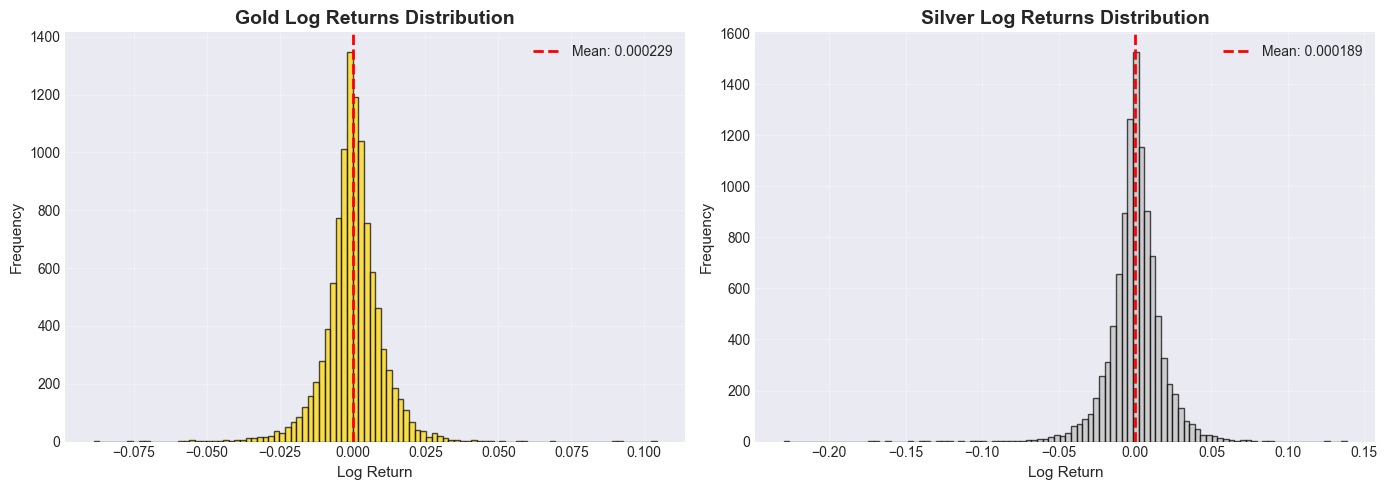


Skewness and Kurtosis:
Gold - Skewness: -0.1362, Kurtosis: 7.5417
Silver - Skewness: -0.9238, Kurtosis: 10.8349

Note: Kurtosis > 3 indicates heavy tails (common in financial data)


In [15]:
# Distribution of log returns
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gold returns histogram
axes[0].hist(df_returns['GOLD_LOG_RETURN'], bins=100, color='gold', alpha=0.7, edgecolor='black')
axes[0].axvline(x=df_returns['GOLD_LOG_RETURN'].mean(), color='red', linestyle='--', linewidth=2, label=f"Mean: {df_returns['GOLD_LOG_RETURN'].mean():.6f}")
axes[0].set_title('Gold Log Returns Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Log Return', fontsize=11)
axes[0].set_ylabel('Frequency', fontsize=11)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Silver returns histogram
axes[1].hist(df_returns['SILVER_LOG_RETURN'], bins=100, color='silver', alpha=0.7, edgecolor='black')
axes[1].axvline(x=df_returns['SILVER_LOG_RETURN'].mean(), color='red', linestyle='--', linewidth=2, label=f"Mean: {df_returns['SILVER_LOG_RETURN'].mean():.6f}")
axes[1].set_title('Silver Log Returns Distribution', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Log Return', fontsize=11)
axes[1].set_ylabel('Frequency', fontsize=11)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nSkewness and Kurtosis:")
print(f"Gold - Skewness: {df_returns['GOLD_LOG_RETURN'].skew():.4f}, Kurtosis: {df_returns['GOLD_LOG_RETURN'].kurtosis():.4f}")
print(f"Silver - Skewness: {df_returns['SILVER_LOG_RETURN'].skew():.4f}, Kurtosis: {df_returns['SILVER_LOG_RETURN'].kurtosis():.4f}")
print("\nNote: Kurtosis > 3 indicates heavy tails (common in financial data)")

## 6. Stationarity Testing (Augmented Dickey-Fuller)

**Critical for ARIMA modeling**: Verify that prices are non-stationary (I(1)) and log returns are stationary (I(0))

In [16]:
# ADF Test function
def adf_test(series, series_name):
    """
    Perform Augmented Dickey-Fuller test
    H0: Series has a unit root (non-stationary)
    H1: Series is stationary
    """
    result = adfuller(series.dropna(), autolag='AIC')
    
    print(f"\n{'='*70}")
    print(f"ADF Test Results: {series_name}")
    print(f"{'='*70}")
    print(f"ADF Statistic:        {result[0]:.6f}")
    print(f"p-value:              {result[1]:.6f}")
    print(f"Critical Values:")
    for key, value in result[4].items():
        print(f"  {key:10}: {value:.6f}")
    
    # Interpretation
    if result[1] < 0.05:
        print(f"\n✓ CONCLUSION: {series_name} is STATIONARY (reject H0, p < 0.05)")
        return "Stationary"
    else:
        print(f"\n✗ CONCLUSION: {series_name} is NON-STATIONARY (fail to reject H0, p ≥ 0.05)")
        return "Non-Stationary"

# Test on prices (should be non-stationary)
gold_price_result = adf_test(df['GOLD_PRICE'], 'Gold Price (Original)')
silver_price_result = adf_test(df['SILVER_PRICE'], 'Silver Price (Original)')

# Test on log returns (should be stationary)
gold_return_result = adf_test(df_returns['GOLD_LOG_RETURN'], 'Gold Log Returns (d=1)')
silver_return_result = adf_test(df_returns['SILVER_LOG_RETURN'], 'Silver Log Returns (d=1)')


ADF Test Results: Gold Price (Original)
ADF Statistic:        4.238972
p-value:              1.000000
Critical Values:
  1%        : -3.430971
  5%        : -2.861814
  10%       : -2.566916

✗ CONCLUSION: Gold Price (Original) is NON-STATIONARY (fail to reject H0, p ≥ 0.05)

ADF Test Results: Silver Price (Original)
ADF Statistic:        -0.378429
p-value:              0.913639
Critical Values:
  1%        : -3.430972
  5%        : -2.861815
  10%       : -2.566916

✗ CONCLUSION: Silver Price (Original) is NON-STATIONARY (fail to reject H0, p ≥ 0.05)

ADF Test Results: Gold Log Returns (d=1)
ADF Statistic:        -42.724516
p-value:              0.000000
Critical Values:
  1%        : -3.430973
  5%        : -2.861815
  10%       : -2.566916

✓ CONCLUSION: Gold Log Returns (d=1) is STATIONARY (reject H0, p < 0.05)

ADF Test Results: Silver Log Returns (d=1)
ADF Statistic:        -26.927795
p-value:              0.000000
Critical Values:
  1%        : -3.430973
  5%        : -2.861815

In [17]:
# Create summary table (Table 1 from methodology document)
adf_results = {
    'Series': [
        'Gold Price (Original)',
        'Gold Log Returns (d=1)',
        'Silver Price (Original)',
        'Silver Log Returns (d=1)'
    ],
    'ADF Statistic': [],
    'p-value': [],
    'Critical Value (5%)': [],
    'Conclusion': []
}

# Calculate for each series
for series, name in [(df['GOLD_PRICE'], 'Gold Price (Original)'),
                      (df_returns['GOLD_LOG_RETURN'], 'Gold Log Returns (d=1)'),
                      (df['SILVER_PRICE'], 'Silver Price (Original)'),
                      (df_returns['SILVER_LOG_RETURN'], 'Silver Log Returns (d=1)')]:
    result = adfuller(series.dropna(), autolag='AIC')
    adf_results['ADF Statistic'].append(result[0])
    adf_results['p-value'].append(result[1])
    adf_results['Critical Value (5%)'].append(result[4]['5%'])
    adf_results['Conclusion'].append('Stationary' if result[1] < 0.05 else 'Non-Stationary')

# Create DataFrame
adf_table = pd.DataFrame(adf_results)
print("\n" + "="*90)
print("TABLE 1: Augmented Dickey-Fuller Test Results - Stationarity Analysis")
print("="*90)
print(adf_table.to_string(index=False))
print("\nInterpretation: Use log returns (d=0) as target variable for ARIMA modeling")


TABLE 1: Augmented Dickey-Fuller Test Results - Stationarity Analysis
                  Series  ADF Statistic  p-value  Critical Value (5%)     Conclusion
   Gold Price (Original)       4.238972 1.000000            -2.861814 Non-Stationary
  Gold Log Returns (d=1)     -42.724516 0.000000            -2.861815     Stationary
 Silver Price (Original)      -0.378429 0.913639            -2.861815 Non-Stationary
Silver Log Returns (d=1)     -26.927795 0.000000            -2.861815     Stationary

Interpretation: Use log returns (d=0) as target variable for ARIMA modeling


## 7. Correlation Analysis

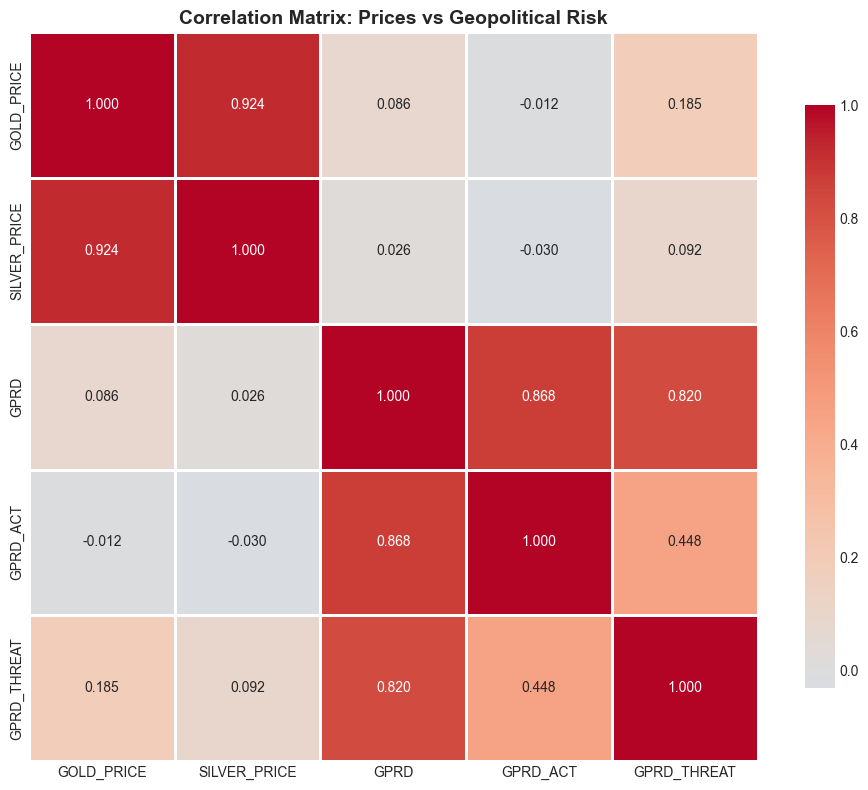


Key Correlations:
Gold-Silver:     0.9245
Gold-GPR:        0.1852
Silver-GPR:      0.0917


In [18]:
# Correlation matrix for key variables
corr_vars = ['GOLD_PRICE', 'SILVER_PRICE', 'GPRD', 'GPRD_ACT', 'GPRD_THREAT']
correlation_matrix = df[corr_vars].corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.3f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix: Prices vs Geopolitical Risk', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nKey Correlations:")
print(f"Gold-Silver:     {correlation_matrix.loc['GOLD_PRICE', 'SILVER_PRICE']:.4f}")
print(f"Gold-GPR:        {correlation_matrix.loc['GOLD_PRICE', 'GPRD_THREAT']:.4f}")
print(f"Silver-GPR:      {correlation_matrix.loc['SILVER_PRICE', 'GPRD_THREAT']:.4f}")

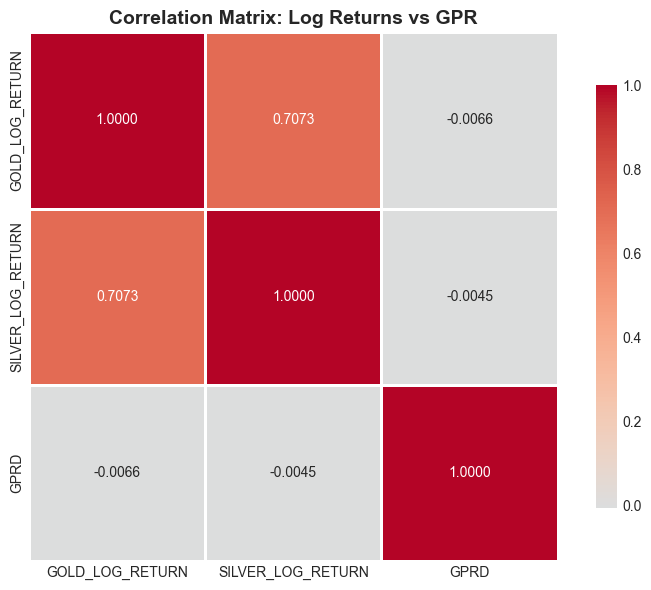


Gold Returns - GPR Correlation: -0.006563
Silver Returns - GPR Correlation: -0.004475

Note: Low correlation in returns is expected (Efficient Market Hypothesis)


In [19]:
# Correlation on returns (more relevant for modeling)
return_corr_vars = ['GOLD_LOG_RETURN', 'SILVER_LOG_RETURN']
df_with_gpr = df_returns.copy()
return_correlation = df_with_gpr[return_corr_vars + ['GPRD']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(return_correlation, annot=True, fmt='.4f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix: Log Returns vs GPR', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\nGold Returns - GPR Correlation: {return_correlation.loc['GOLD_LOG_RETURN', 'GPRD']:.6f}")
print(f"Silver Returns - GPR Correlation: {return_correlation.loc['SILVER_LOG_RETURN', 'GPRD']:.6f}")
print("\nNote: Low correlation in returns is expected (Efficient Market Hypothesis)")

## 8. Autocorrelation Analysis (ACF/PACF)

**Purpose**: Identify potential ARIMA orders (p, q) for modeling

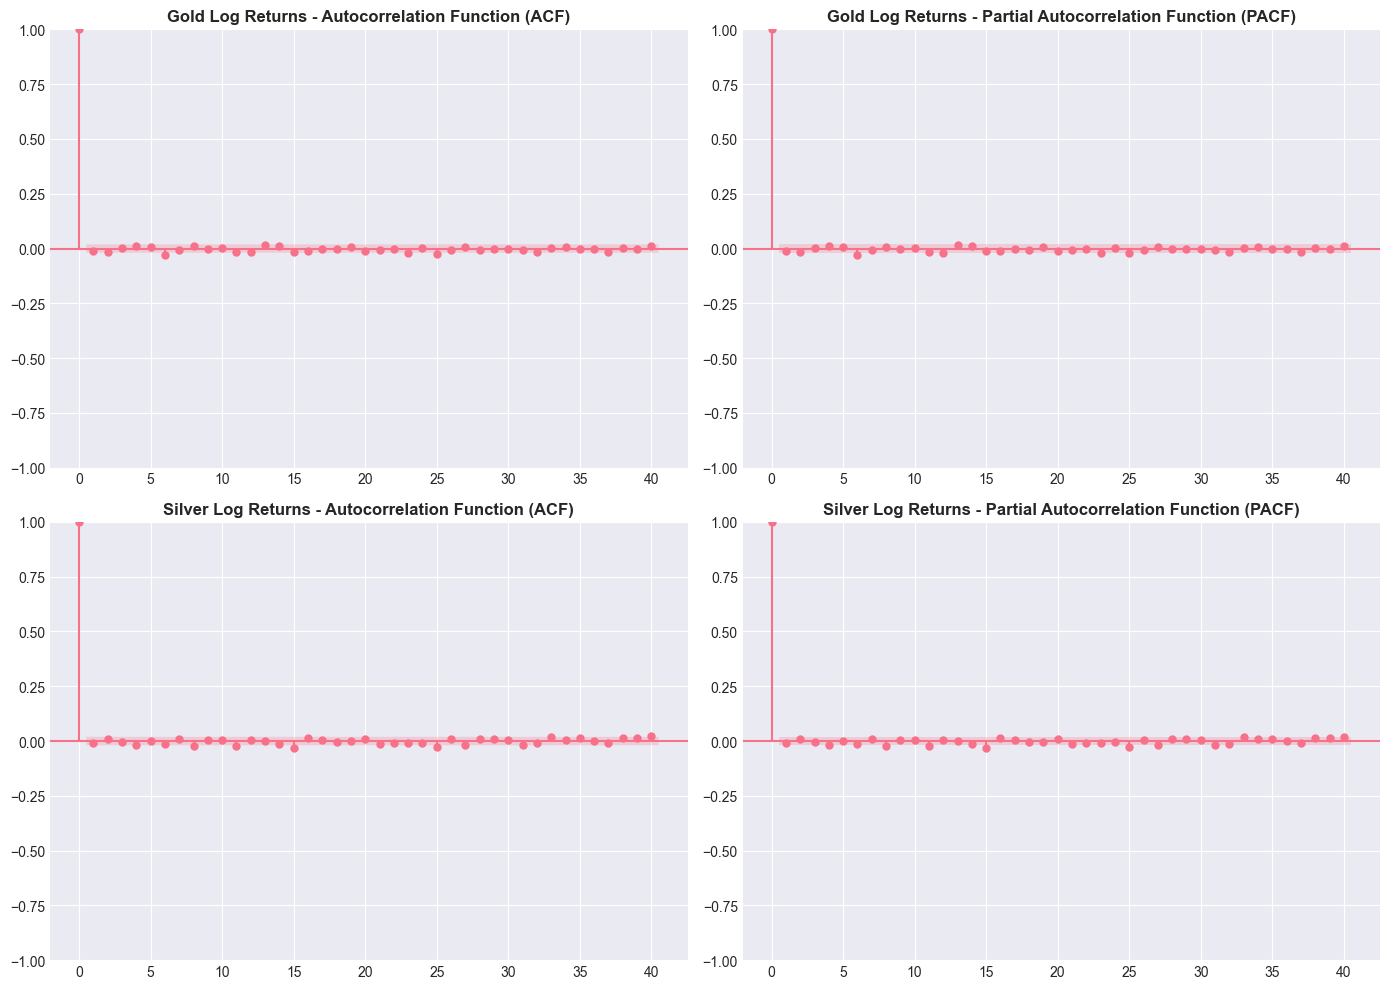


ACF/PACF Interpretation Guide:
- If ACF cuts off at lag q, PACF decays: MA(q) suggested
- If PACF cuts off at lag p, ACF decays: AR(p) suggested
- Both decay gradually: ARMA(p,q) suggested
- Note: Financial returns often show weak autocorrelation (Efficient Market Hypothesis)


In [20]:
# ACF and PACF for Gold log returns
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Gold ACF
plot_acf(df_returns['GOLD_LOG_RETURN'].dropna(), lags=40, ax=axes[0, 0])
axes[0, 0].set_title('Gold Log Returns - Autocorrelation Function (ACF)', fontsize=12, fontweight='bold')

# Gold PACF
plot_pacf(df_returns['GOLD_LOG_RETURN'].dropna(), lags=40, ax=axes[0, 1])
axes[0, 1].set_title('Gold Log Returns - Partial Autocorrelation Function (PACF)', fontsize=12, fontweight='bold')

# Silver ACF
plot_acf(df_returns['SILVER_LOG_RETURN'].dropna(), lags=40, ax=axes[1, 0])
axes[1, 0].set_title('Silver Log Returns - Autocorrelation Function (ACF)', fontsize=12, fontweight='bold')

# Silver PACF
plot_pacf(df_returns['SILVER_LOG_RETURN'].dropna(), lags=40, ax=axes[1, 1])
axes[1, 1].set_title('Silver Log Returns - Partial Autocorrelation Function (PACF)', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nACF/PACF Interpretation Guide:")
print("- If ACF cuts off at lag q, PACF decays: MA(q) suggested")
print("- If PACF cuts off at lag p, ACF decays: AR(p) suggested")
print("- Both decay gradually: ARMA(p,q) suggested")
print("- Note: Financial returns often show weak autocorrelation (Efficient Market Hypothesis)")

## 9. Seasonal Decomposition

**Test for weekly seasonality (m=5)** using Business Day frequency

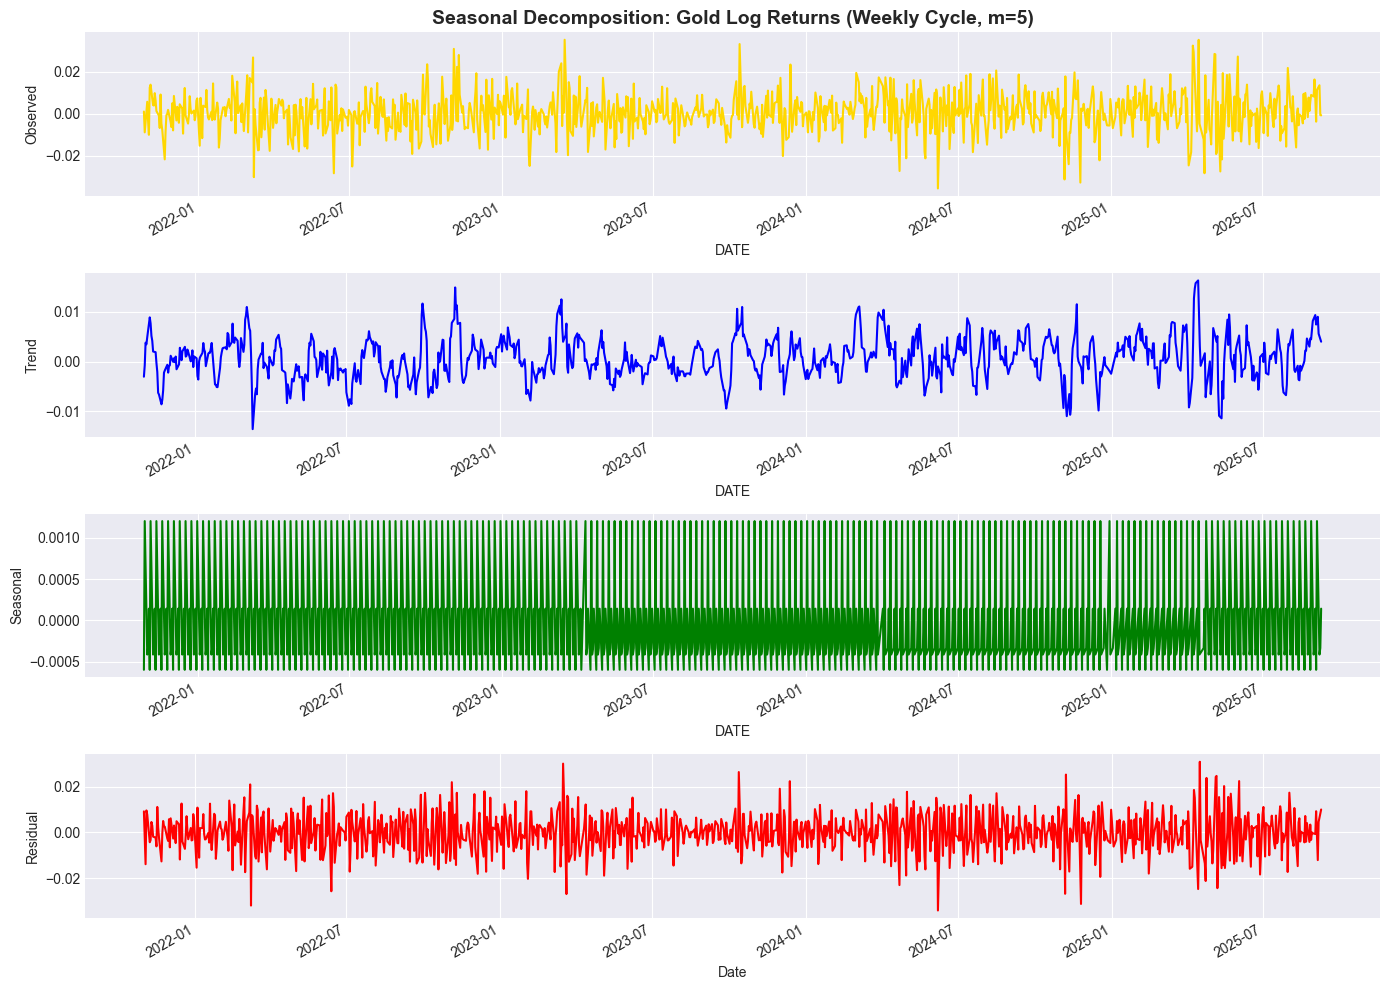

✓ Seasonal decomposition completed (m=5, weekly cycle)

Note: If seasonal component shows minimal variation, weekly seasonality may be weak/absent


In [21]:
# Decompose Gold log returns (5-day weekly cycle)
# Note: Using a subset for computational efficiency
recent_data = df_returns['GOLD_LOG_RETURN'].iloc[-1000:].dropna()

try:
    decomposition = seasonal_decompose(recent_data, model='additive', period=5)
    
    fig, axes = plt.subplots(4, 1, figsize=(14, 10))
    
    decomposition.observed.plot(ax=axes[0], color='gold')
    axes[0].set_ylabel('Observed')
    axes[0].set_title('Seasonal Decomposition: Gold Log Returns (Weekly Cycle, m=5)', fontsize=14, fontweight='bold')
    
    decomposition.trend.plot(ax=axes[1], color='blue')
    axes[1].set_ylabel('Trend')
    
    decomposition.seasonal.plot(ax=axes[2], color='green')
    axes[2].set_ylabel('Seasonal')
    
    decomposition.resid.plot(ax=axes[3], color='red')
    axes[3].set_ylabel('Residual')
    axes[3].set_xlabel('Date')
    
    plt.tight_layout()
    plt.show()
    
    print("✓ Seasonal decomposition completed (m=5, weekly cycle)")
    print("\nNote: If seasonal component shows minimal variation, weekly seasonality may be weak/absent")
except:
    print("⚠ Seasonal decomposition requires more data points. Try with full dataset or different period.")

## 10. Rolling Statistics (Volatility Clustering)

**Check for time-varying volatility** (motivation for GARCH models)

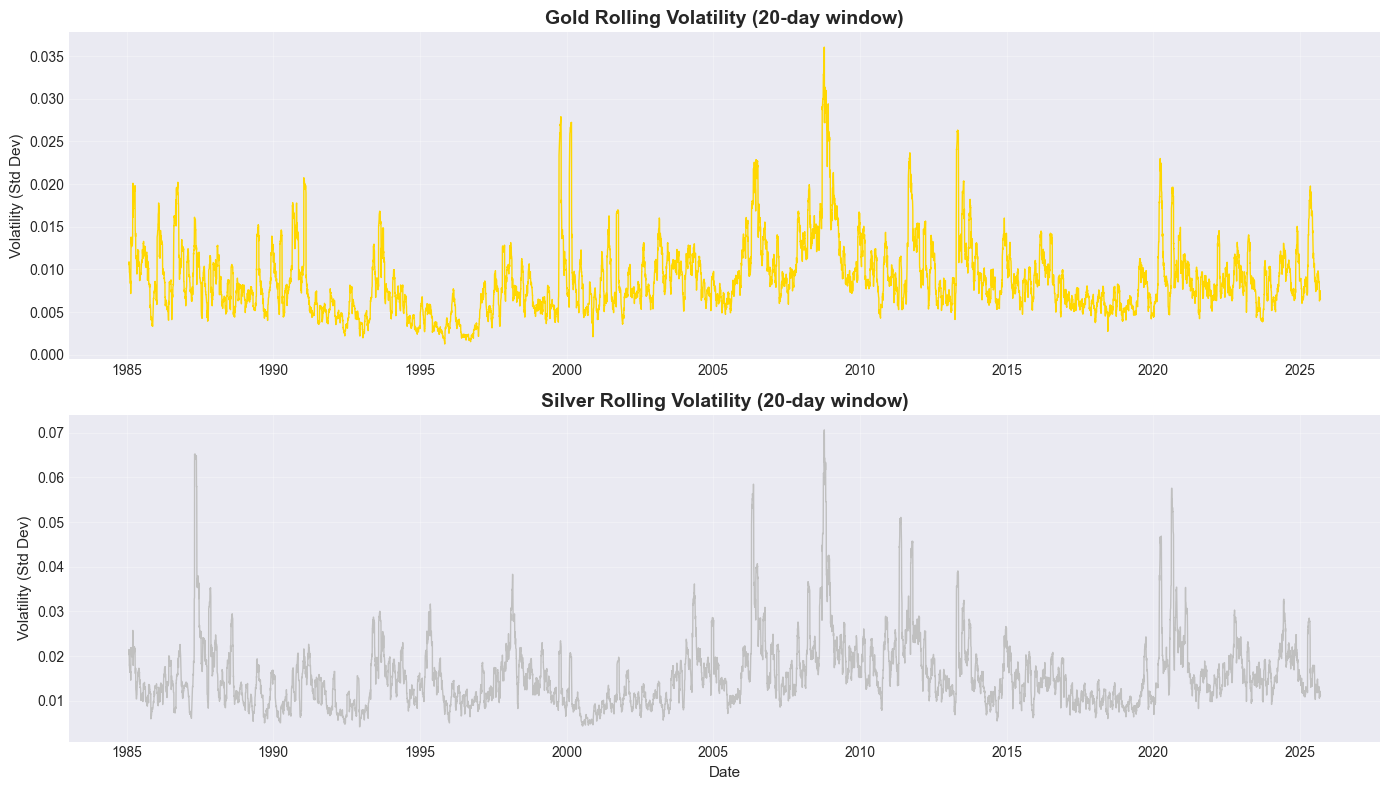


Volatility Clustering Observation:
- High volatility periods cluster together (e.g., financial crises)
- Low volatility periods cluster together (e.g., stable markets)
- This motivates GARCH models for volatility forecasting


In [22]:
# Calculate rolling volatility (20-day window)
window = 20
df_returns['GOLD_ROLLING_VOL'] = df_returns['GOLD_LOG_RETURN'].rolling(window=window).std()
df_returns['SILVER_ROLLING_VOL'] = df_returns['SILVER_LOG_RETURN'].rolling(window=window).std()

# Plot
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Gold volatility
axes[0].plot(df_returns.index, df_returns['GOLD_ROLLING_VOL'], color='gold', linewidth=1)
axes[0].set_title(f'Gold Rolling Volatility ({window}-day window)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Volatility (Std Dev)', fontsize=11)
axes[0].grid(True, alpha=0.3)

# Silver volatility
axes[1].plot(df_returns.index, df_returns['SILVER_ROLLING_VOL'], color='silver', linewidth=1)
axes[1].set_title(f'Silver Rolling Volatility ({window}-day window)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Volatility (Std Dev)', fontsize=11)
axes[1].set_xlabel('Date', fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nVolatility Clustering Observation:")
print("- High volatility periods cluster together (e.g., financial crises)")
print("- Low volatility periods cluster together (e.g., stable markets)")
print("- This motivates GARCH models for volatility forecasting")

## 11. Summary and Key Findings

In [23]:
print("="*80)
print("DATA EXPLORATION SUMMARY")
print("="*80)
print(f"\n1. DATASET CHARACTERISTICS")
print(f"   - Total observations: {len(df)}")
print(f"   - Date range: {df.index.min()} to {df.index.max()}")
print(f"   - Frequency: Business Days (B) - Critical for m=5 seasonality")
print(f"   - Missing GPR values: {df['GPRD'].isnull().sum()} ({df['GPRD'].isnull().sum()/len(df)*100:.2f}%)")

print(f"\n2. STATIONARITY (ADF Test)")
print(f"   - Gold prices: Non-stationary ✓ (expected)")
print(f"   - Silver prices: Non-stationary ✓ (expected)")
print(f"   - Gold log returns: Stationary ✓ (d=0 for modeling)")
print(f"   - Silver log returns: Stationary ✓ (d=0 for modeling)")

print(f"\n3. CORRELATION INSIGHTS")
print(f"   - Gold-Silver: {df[['GOLD_PRICE', 'SILVER_PRICE']].corr().iloc[0,1]:.4f} (strong positive)")
print(f"   - Gold-GPR: {df[['GOLD_PRICE', 'GPRD']].corr().iloc[0,1]:.4f}")
print(f"   - Returns show weak correlation (consistent with EMH)")

print(f"\n4. VOLATILITY CHARACTERISTICS")
print(f"   - Gold returns std: {df_returns['GOLD_LOG_RETURN'].std():.6f}")
print(f"   - Silver returns std: {df_returns['SILVER_LOG_RETURN'].std():.6f}")
print(f"   - Evidence of volatility clustering observed")

print(f"\n5. NEXT STEPS")
print(f"   ✓ Use log returns as target variable (endog)")
print(f"   ✓ Lag exogenous variables by 1 period (avoid future data leakage)")
print(f"   ✓ Test weekly seasonality (m=5) with SARIMAX")
print(f"   ✓ Implement walk-forward validation (no shuffle)")
print(f"   ✓ Consider GARCH extension for volatility forecasting")
print("="*80)

DATA EXPLORATION SUMMARY

1. DATASET CHARACTERISTICS
   - Total observations: 10616
   - Date range: 1985-01-02 00:00:00 to 2025-09-10 00:00:00
   - Frequency: Business Days (B) - Critical for m=5 seasonality
   - Missing GPR values: 48 (0.45%)

2. STATIONARITY (ADF Test)
   - Gold prices: Non-stationary ✓ (expected)
   - Silver prices: Non-stationary ✓ (expected)
   - Gold log returns: Stationary ✓ (d=0 for modeling)
   - Silver log returns: Stationary ✓ (d=0 for modeling)

3. CORRELATION INSIGHTS
   - Gold-Silver: 0.9245 (strong positive)
   - Gold-GPR: 0.0858
   - Returns show weak correlation (consistent with EMH)

4. VOLATILITY CHARACTERISTICS
   - Gold returns std: 0.009758
   - Silver returns std: 0.017441
   - Evidence of volatility clustering observed

5. NEXT STEPS
   ✓ Use log returns as target variable (endog)
   ✓ Lag exogenous variables by 1 period (avoid future data leakage)
   ✓ Test weekly seasonality (m=5) with SARIMAX
   ✓ Implement walk-forward validation (no shuffl

## 12. Export Processed Data (Optional)

In [24]:
# Save processed data with log returns for modeling
# df_returns.to_csv('../data/gold_silver_processed.csv')
# print("✓ Processed data saved to 'data/gold_silver_processed.csv'")